In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *
from abtem.utils import GaussianDistribution
from ase.io import read
from ase.build import surface, bulk
from tqdm.auto import tqdm
from ase.build import graphene

from tqdm.auto import tqdm
from abtem.structures import orthogonalize_cell
from abtem.measure import center_of_mass

# Partial coherence in 4D-STEM

This notebook approximately reproduces the results of https://doi.org/10.1016/j.ultramic.2020.113015.

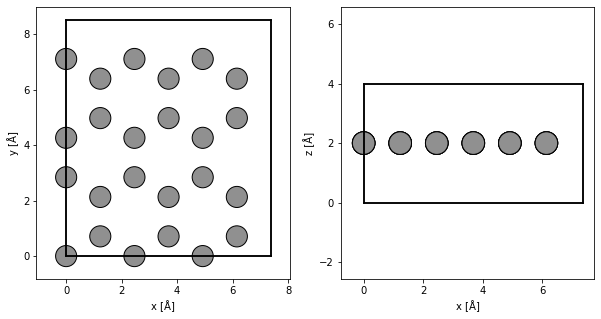

In [2]:
atoms = graphene()
atoms = orthogonalize_cell(atoms)
atoms *= (3,2,1)

atoms.center(vacuum=2, axis=2)
#atoms.center()

fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='xz');

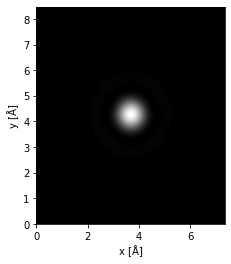

In [46]:
energy = 60e3

probe = SMatrix(energy=energy, semiangle_cutoff=30, device='gpu')
potential = Potential(atoms, #FrozenPhonons(atoms, sigmas=.06, num_configs=32), 
                      sampling=.04, 
                      projection='infinite',
                      parametrization='kirkland')
probe.grid.match(potential)

probe.downsampled_gpts('valid')

probe.build().collapse().show();

In [47]:
scan = GridScan((2.46 / 2, 0), (potential.extent[0] / 3 + 2.46 / 2, potential.extent[1] / 2), sampling = .1)
detector = PixelatedDetector()

In [48]:
measurement = probe.scan(scan, detector, potential, pbar=False)

(<AxesSubplot:title={'center':'Slice (0, 0) of (25, 43, 86, 99) measurement'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x20d2d3a02e0>)

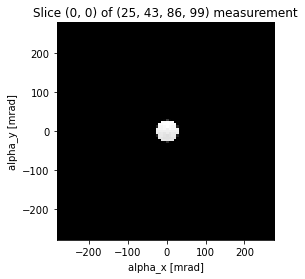

In [49]:
measurement.show()

In [50]:
energy_spread = 0.35
Cc = 1.2e7
focal_spread = energy_spread / energy * Cc / 2.355 # 2.355 converts from FWHM to standard deviation

S = probe.multislice(potential, pbar=False)
S = S.downsample()
measurement_temporal = detector.allocate_measurement(S, scan)

for defocus, intensity in tqdm(GaussianDistribution(0, 30, 51), desc='Defocus'):
    S.ctf.defocus = defocus
    measurement_temporal += S.scan(scan, detector, pbar=False) * intensity

In [51]:
measurement_spatial = measurement.gaussian_filter((.75 / 2.355,) * 2 + (0.,) * 2)

measurement_temporal_spatial = measurement_temporal.gaussian_filter((.75 / 2.355,) * 2 + (0.,) * 2)

In [52]:
com = center_of_mass(measurement, return_magnitude=True)
com_temporal = center_of_mass(measurement_temporal, return_magnitude=True)
com_spatial = center_of_mass(measurement_spatial, return_magnitude=True)
com_temporal_spatial = center_of_mass(measurement_temporal_spatial, return_magnitude=True)

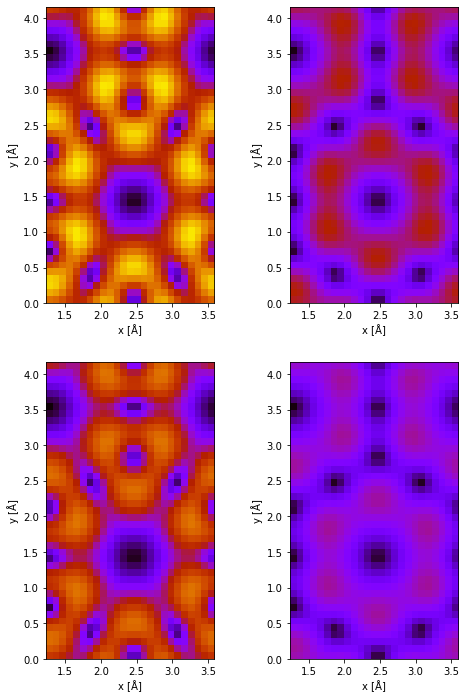

In [53]:
cmap = 'gnuplot'

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,12))

com.show(cmap=cmap, vmin=0, vmax=.7, ax=ax1)
com_temporal.show(cmap=cmap, vmin=0, vmax=.7, ax=ax3)
com_spatial.show(cmap=cmap, vmin=0, vmax=.7, ax=ax2)
com_temporal_spatial.show(cmap=cmap, vmin=0, vmax=.7, ax=ax4);